# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.257  train_ave_acc: 0.542  (3.15s - 626.10s remaining) ave_loss: 0.2565890102704599 ave_acc: 0.5415173243427768
EPOCH: 2.000  train_ave_loss: 0.245  train_ave_acc: 0.587  (5.93s - 586.77s remaining) ave_loss: 0.2445052396232956 ave_acc: 0.5867597195011769
EPOCH: 3.000  train_ave_loss: 0.238  train_ave_acc: 0.610  (8.67s - 569.35s remaining) ave_loss: 0.23780774551817924 ave_acc: 0.6103764003899145
EPOCH: 4.000  train_ave_loss: 0.236  train_ave_acc: 0.614  (11.40s - 558.70s remaining) ave_loss: 0.2359088630882526 ave_acc: 0.6143663917379767
EPOCH: 5.000  train_ave_loss: 0.230  train_ave_acc: 0.611  (14.15s - 551.90s remaining) ave_loss: 0.23021070334699847 ave_acc: 0.6106219633947876
EPOCH: 6.000  train_ave_loss: 0.223  train_ave_acc: 0.624  (16.91s - 546.67s remaining) ave_loss: 0.22341979272073664 ave_acc: 0.6242496940059846
EPOCH: 7.000  train_ave_loss: 0.221  train_ave_acc: 0.623  (19.70s - 543.09s remaining) ave_loss: 0.22142761920051665 ave_acc: 0.6

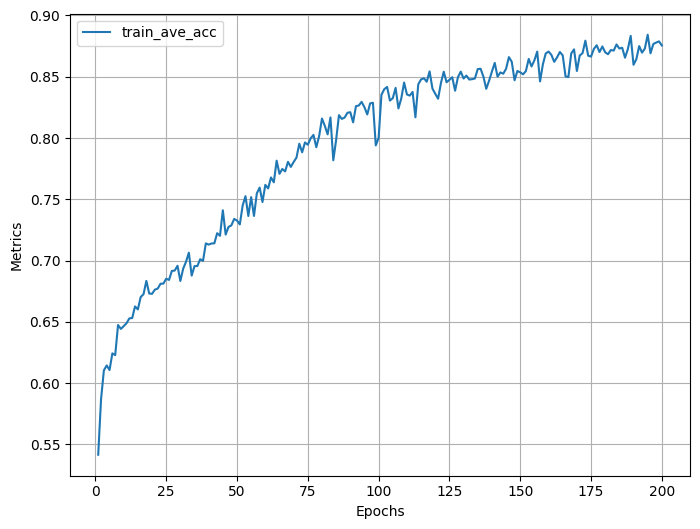

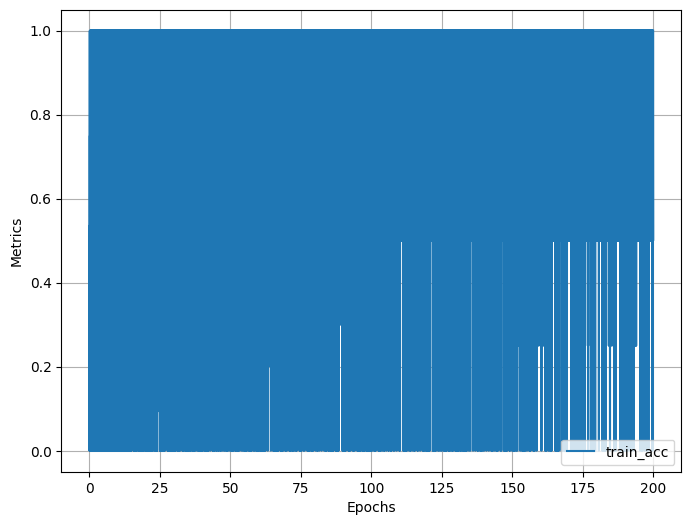

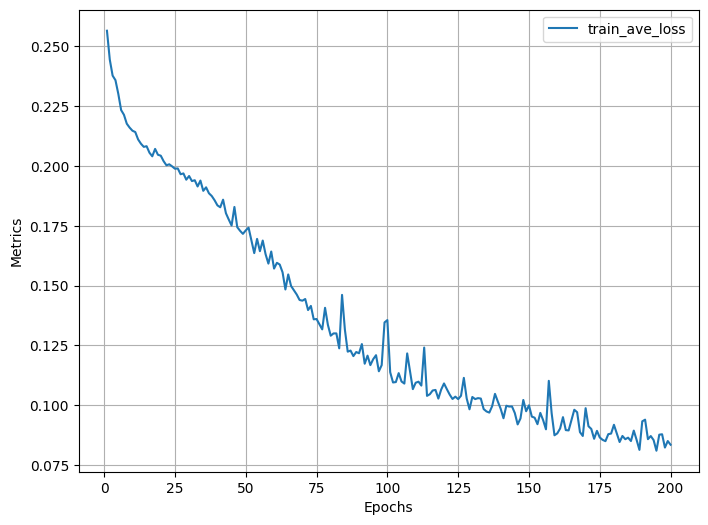

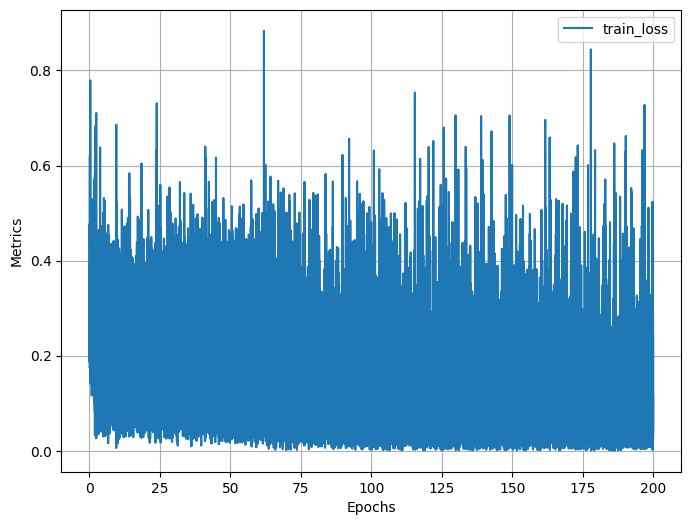

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5935162094763092
NN MC MSE: 0.31585172607346895
NN MC Seq Accuracy: 0.6396508728179551
NN MC Seq MSE: 0.28988947174296276


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.160  train_ave_acc: 0.509  (2.58s - 513.79s remaining) ave_loss: 0.1601000728844897 ave_acc: 0.5087593978311046
EPOCH: 2.000  train_ave_loss: 0.132  train_ave_acc: 0.529  (5.11s - 505.53s remaining) ave_loss: 0.13199326527903069 ave_acc: 0.528701159608514
EPOCH: 3.000  train_ave_loss: 0.127  train_ave_acc: 0.536  (7.59s - 498.22s remaining) ave_loss: 0.1271762105081875 ave_acc: 0.536466329241063
EPOCH: 4.000  train_ave_loss: 0.122  train_ave_acc: 0.541  (10.08s - 493.79s remaining) ave_loss: 0.12179489403722747 ave_acc: 0.5408262083345616
EPOCH: 5.000  train_ave_loss: 0.123  train_ave_acc: 0.546  (12.59s - 490.89s remaining) ave_loss: 0.12314948827421561 ave_acc: 0.5457978894076858
EPOCH: 6.000  train_ave_loss: 0.121  train_ave_acc: 0.544  (15.06s - 487.08s remaining) ave_loss: 0.1207787902080768 ave_acc: 0.5443677205646645
EPOCH: 7.000  train_ave_loss: 0.100  train_ave_acc: 0.582  (17.53s - 483.30s remaining) ave_loss: 0.09999442803250118 ave_acc: 0.581

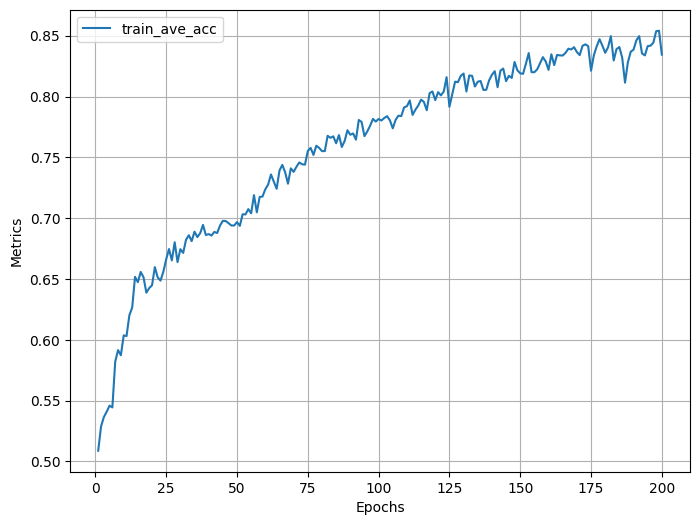

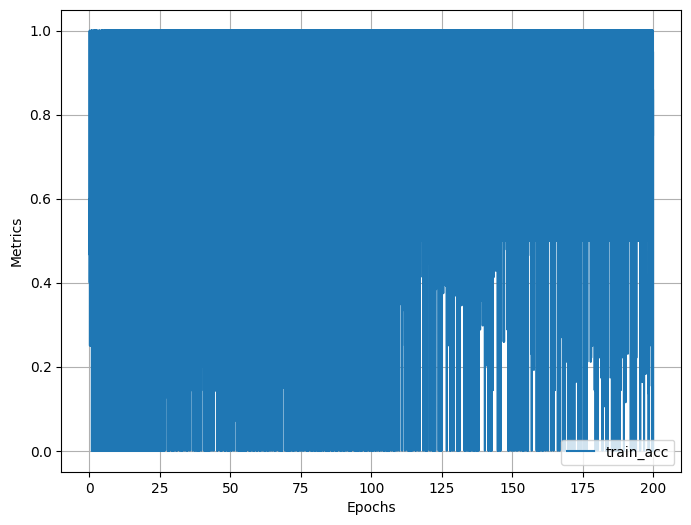

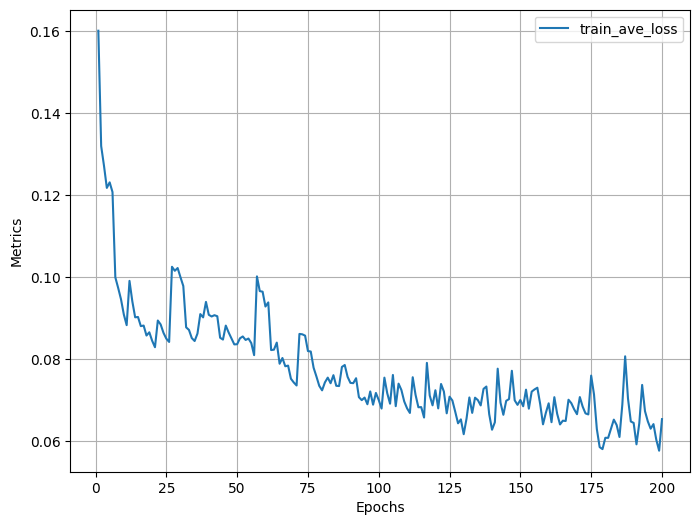

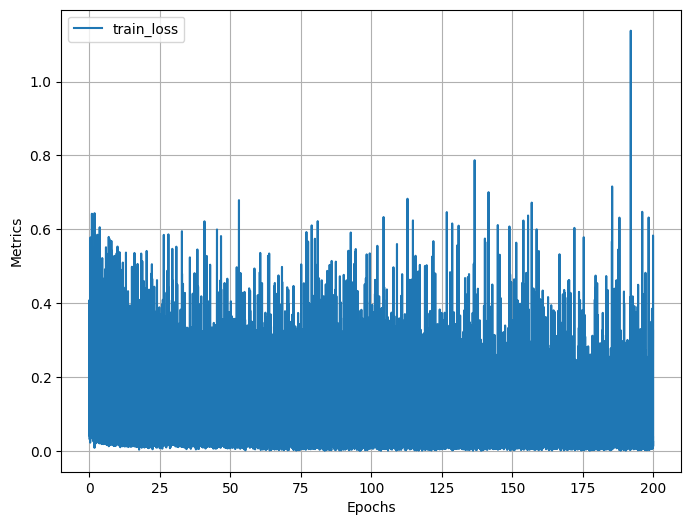

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5548628428927681
NN Sarsa MSE: 0.2877703613145749
NN Sarsa Seq Accuracy: 0.5947630922693267
NN Sarsa Seq MSE: 0.27828436906594206


#### Training (With MC Init)

In [34]:
import d_sarsa

mc_init_epochs = 100
sarsa_epochs = 200

print("MC INIT TRAINING")
nn_sarsa_with_mc_mc_model, nn_sarsa_with_mc_mc_report = d_sarsa.train(save=False, use_mc=False, num_epochs=mc_init_epochs)

print("SARASA WITH MC INIT TRAINING")
nn_mc_state_dict = nn_sarsa_with_mc_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict, num_epochs=sarsa_epochs)

MC INIT TRAINING
EPOCH: 1.000  train_ave_loss: 0.165  train_ave_acc: 0.523  (4.56s - 451.11s remaining) ave_loss: 0.16450802029774161 ave_acc: 0.5228714583645564
EPOCH: 2.000  train_ave_loss: 0.137  train_ave_acc: 0.519  (9.33s - 457.24s remaining) ave_loss: 0.13673683395199587 ave_acc: 0.5192462516188263
EPOCH: 3.000  train_ave_loss: 0.134  train_ave_acc: 0.518  (12.74s - 412.06s remaining) ave_loss: 0.13408502709677667 ave_acc: 0.5179868424350598
EPOCH: 4.000  train_ave_loss: 0.129  train_ave_acc: 0.532  (16.68s - 400.22s remaining) ave_loss: 0.12906266162800126 ave_acc: 0.5322358887370514
EPOCH: 5.000  train_ave_loss: 0.125  train_ave_acc: 0.540  (21.95s - 417.14s remaining) ave_loss: 0.1251588746402795 ave_acc: 0.5395570988494279
EPOCH: 6.000  train_ave_loss: 0.131  train_ave_acc: 0.528  (26.39s - 413.44s remaining) ave_loss: 0.13075988530249627 ave_acc: 0.5279943195030065
EPOCH: 7.000  train_ave_loss: 0.109  train_ave_acc: 0.551  (29.77s - 395.50s remaining) ave_loss: 0.1086787460

MC INIT PLOTS


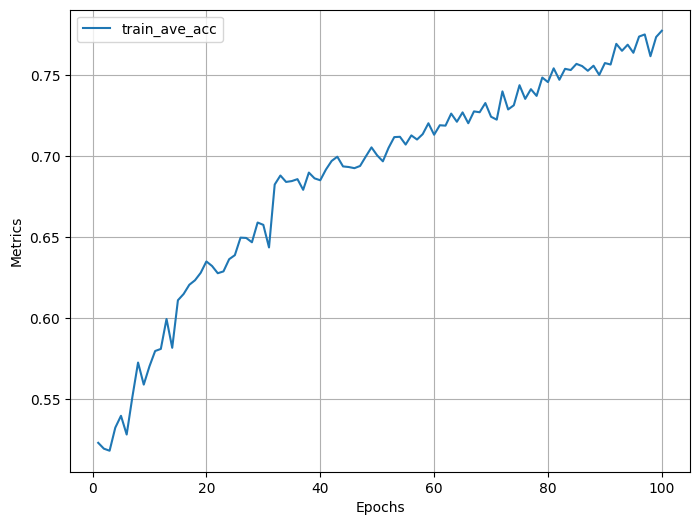

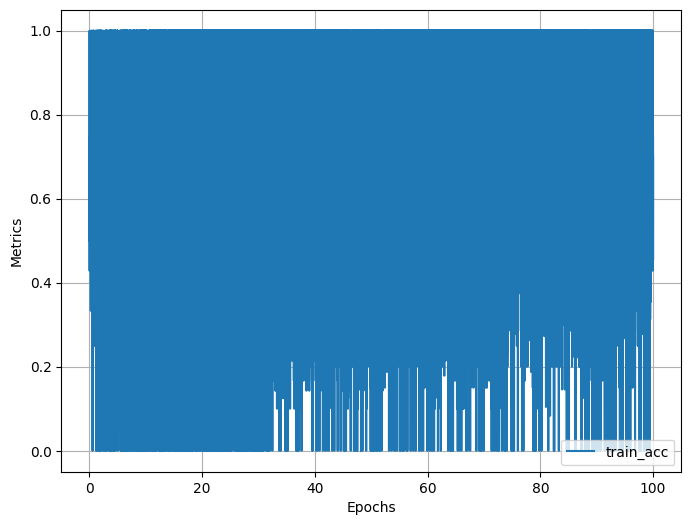

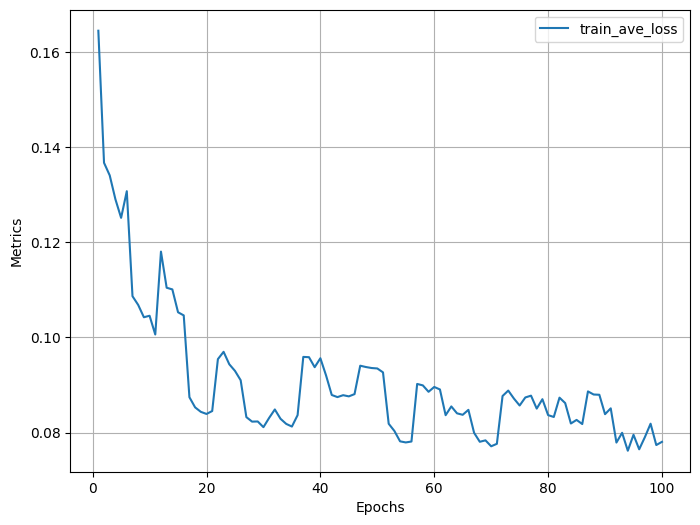

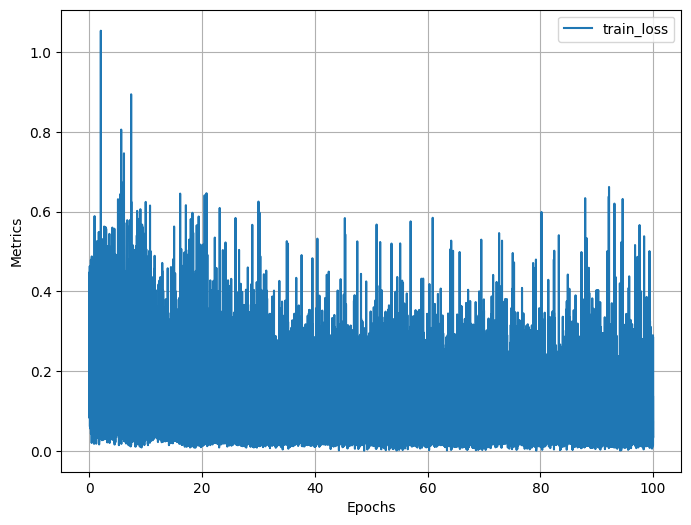

SARSA WITH MC INIT PLOTS


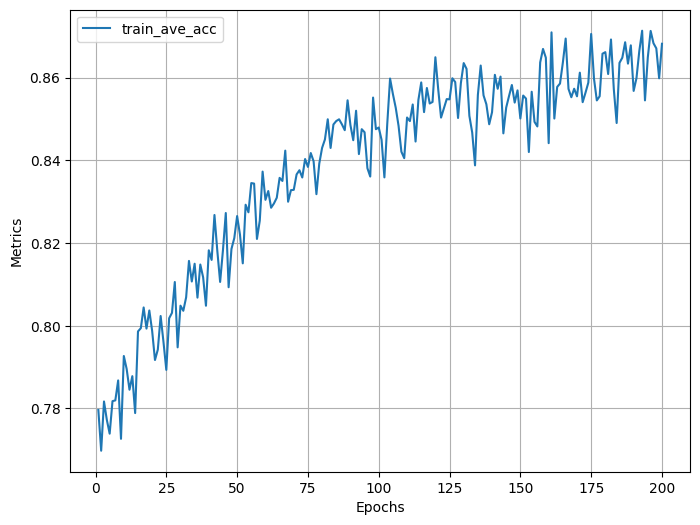

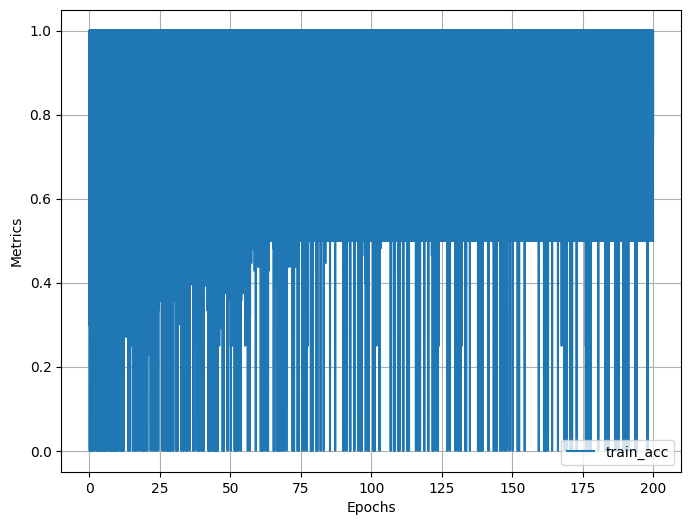

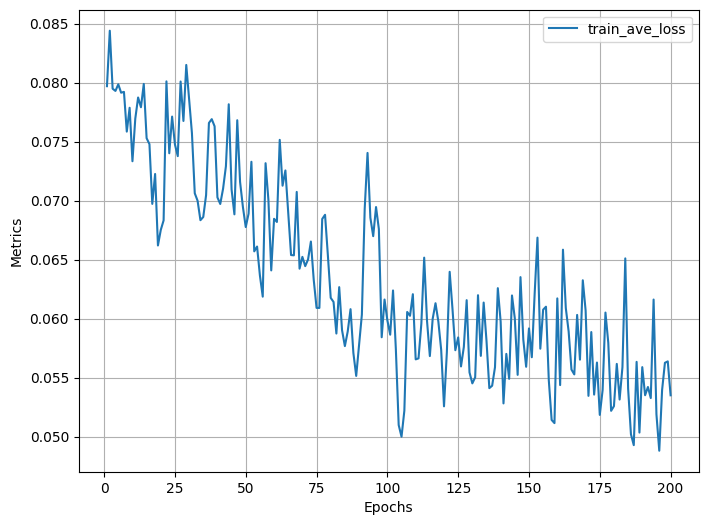

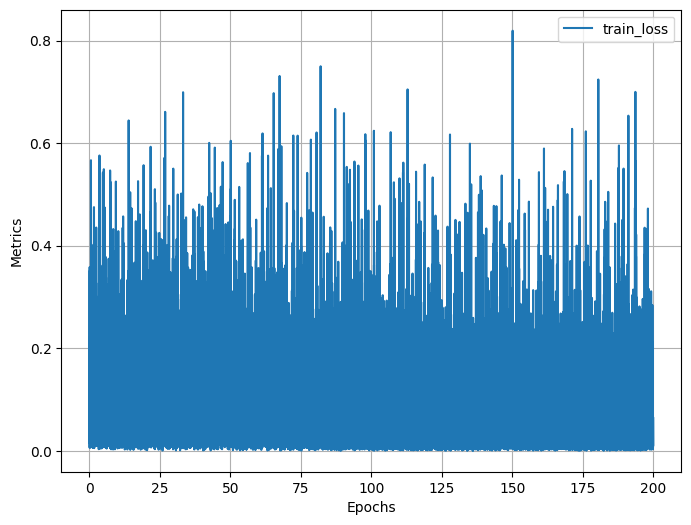

In [36]:
print("MC INIT PLOTS")
nn_sarsa_with_mc_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_mc_report.plot('train_acc')
nn_sarsa_with_mc_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_mc_report.plot('train_loss')

print("SARSA WITH MC INIT PLOTS")
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [35]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_mc_model.eval()
def nn_sarsa_with_mc_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_mc_score, nn_sarsa_with_mc_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_mc_predict)

def nn_sarsa_with_mc_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_mc_seq_score, nn_sarsa_with_mc_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_mc_predict_seq)

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print("MC INIT EVALS")
print(f"NN MC Init Accuracy: {nn_sarsa_with_mc_mc_score}")
print(f"NN MC Init MSE: {nn_sarsa_with_mc_mc_mse}")
print(f"NN MC Init Seq Accuracy: {nn_sarsa_with_mc_mc_seq_score}")
print(f"NN MC Init Seq MSE: {nn_sarsa_with_mc_mc_seq_mse}")

print("SARSA WITH MC INIT EVALS")
print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

MC INIT EVALS
NN MC Init Accuracy: 0.5660847880299252
NN MC Init MSE: 0.29423718570539176
NN MC Init Seq Accuracy: 0.6172069825436409
NN MC Init Seq MSE: 0.24293828777279744
SARSA WITH MC INIT EVALS
NN Sarsa With MC Init Accuracy: 0.5698254364089775
NN Sarsa With MC Init MSE: 0.3148506524985009
NN Sarsa With MC Init Seq Accuracy: 0.6271820448877805
NN Sarsa With MC Init Seq MSE: 0.26664950260615866


In [32]:
import os

model_dirpath = 'experiment_models/controlled_mc_200epoch_e-3lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions